# Пример использования библиотеки BigARTM для тематического моделирования

Импортируем BigARTM:

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import artm

In [4]:
# check 
artm.version()

'0.8.3'

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [6]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем словарь и объект модели:

In [7]:
my_dictionary = artm.Dictionary()
my_dictionary.gather(data_path='school_batches')

In [8]:
# check default name
my_dictionary.name

'2a0a6361-7eb1-47df-8a01-69627922a65d'

In [9]:
T = 10   # количество тем
# added cache_theta=True in order to be able to print theta in the end of this notebook. Can be done only for small collections
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, cache_theta=True)
# число после названия модальностей - это их веса

In [10]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary = my_dictionary))

In [41]:
#model = artm.ARTM(num_topics=20, dictionary=my_dictionary)

In [42]:
#model.scores.add(artm.PerplexityScore(name='my_fisrt_perplexity_score',
                                      #use_unigram_document_model=False,
                                      #dictionary=my_dictionary))

In [11]:
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Инициализируем модель с помощью созданного ранее словаря

In [12]:
#model_artm.gather_dictionary('dictionary', batch_vectorizer.data_path)

In [13]:
model_artm.initialize(dictionary=my_dictionary)

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [15]:
#model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40, num_document_passes=1)
# looks like it only uses default num_document_passes=1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

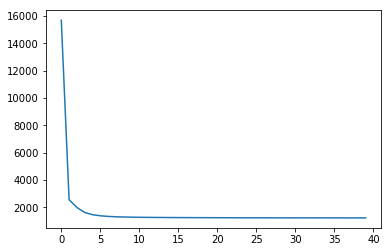

In [16]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [17]:
# OLD. throws AttributeError: 'TopTokensScoreTracker' object has no attribute 'last_topic_info' in version '0.8.3'
#for topic_name in model_artm.topic_names:
#    print topic_name + ': ',
#    for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
#        print word,
#    print

In [18]:
# tokens from last update of Phi
saved_top_tokens = model_artm.score_tracker['top_words'].last_tokens
# print top tokens
for topic_name in model_artm.topic_names:
    print topic_name, ', '.join([x for x in saved_top_tokens[topic_name]])

sbj0 быть, право, который, ребенок, человек, язык, они, семья, это, русский, время, для, также, свой, что
sbj1 что, свой, который, быть, это, человек, этот, его, герой, она, они, жизнь, ребенок, как, такой
sbj2 предложение, слово, который, что, например, это, как, быть, или, речь, такой, они, если, мочь, этот
sbj3 который, что, ядро, это, этот, энергия, вода, земля, быть, масса, атом, как, температура, такой, океан
sbj4 поэт, пушкин, что, стихотворение, который, свой, это, быть, звук, этот, весь, лирика, год, его, произведение
sbj5 x, быть, a, b, число, этот, при, функция, уравнение, что, это, для, если, сила, ток
sbj6 который, человек, свой, что, жизнь, его, быть, герой, это, как, произведение, литература, этот, для, русский
sbj7 который, человек, общество, развитие, социальный, государство, как, политический, быть, это, себя, культура, жизнь, такой, отношение
sbj8 страна, государство, население, который, быть, территория, этот, год, являться, город, африка, время, что, также, хозяйст

Давайте посмотрим также на разреженность матриц:

In [19]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.767712280266
0.00189075630252


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [20]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=my_dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [21]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [22]:
# check tokens after tau regularizer change
# tokens from last update of Phi
saved_top_tokens = model_artm.score_tracker['top_words'].last_tokens
# print top tokens
for topic_name in model_artm.topic_names:
    print topic_name, ', '.join([x for x in saved_top_tokens[topic_name]])

sbj0 быть, право, который, ребенок, человек, язык, они, семья, это, время, для, также, свой, русский, что
sbj1 что, свой, который, быть, это, человек, герой, этот, его, она, они, жизнь, как, такой, ребенок
sbj2 предложение, слово, который, что, например, это, как, быть, или, речь, такой, они, если, мочь, предмет
sbj3 который, что, ядро, это, энергия, этот, земля, вода, быть, масса, атом, как, температура, такой, океан
sbj4 поэт, пушкин, что, стихотворение, который, свой, это, быть, этот, весь, звук, лирика, год, его, произведение
sbj5 x, быть, a, b, число, этот, при, функция, уравнение, что, это, для, если, сила, ток
sbj6 который, человек, свой, что, жизнь, его, быть, герой, это, как, произведение, литература, этот, для, литературный
sbj7 который, человек, общество, развитие, социальный, государство, как, политический, это, быть, себя, культура, жизнь, такой, отношение
sbj8 страна, государство, население, который, быть, территория, этот, год, являться, город, африка, что, время, также,

Попробуем менять коэффициент регуляризации:

In [23]:
# OLD it results in empty model_artm.score_tracker['top_words'].last_tokens
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [24]:
# NEW a bigger value
#model_artm.regularizers['SparsePhi'].tau = -100

In [25]:
# OLD num_document_passes=1 throws fit_offline() got an unexpected keyword argument 'num_document_passes'
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15, num_document_passes=1)

In [26]:
%%time
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Wall time: 5.58 s


In [27]:
# OLD
#for topic_name in model_artm.topic_names:
#    print topic_name + ': ',
#    for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
#        print word,
#    print

In [28]:
# check tokens after 2nd tau regularizer change
# tokens from last update of Phi
saved_top_tokens = model_artm.score_tracker['top_words'].last_tokens

In [29]:
print 'dict size ', len(saved_top_tokens.keys())

dict size  10


In [30]:
# print top tokens
for topic_name in model_artm.topic_names:
    print topic_name, ', '.join([x for x in saved_top_tokens[topic_name]])
    #print topic_name, saved_top_tokens[topic_name]

sbj0 право, ребенок, язык, свобода, семья, английский, религиозный, гражданский, быт, суд, воспитание, честь, орган, the, закреплять
sbj1 жить, повесть, женщина, нет, поэма, лермонтов, написать, школа, молодой, сказка, отец, хороший, любить, гоголь, умирать
sbj2 слово, например, предложение, простой, какой, предмет, речь, глагол, скорость, физика, имя, выступать, свет, кто, признак
sbj3 земля, энергия, вода, ядро, масса, движение, природный, состоять, океан, частица, атом, заряд, температура, располагать, южный
sbj4 пушкин, поэт, стихотворение, лирика, звук, писать, стих, поэзия, сравнение, почти, ночь, русь, былина, красота, любовный
sbj5 при, x, a, сила, если, два, число, можно, b, функция, пример, получать, тело, равный, случай
sbj6 человек, его, жизнь, герой, русский, главный, произведение, мир, литература, сам, история, автор, литературный, личность, всегда
sbj7 общество, представлять, развитие, отношение, социальный, политический, процесс, форма, система, экономический, производс

In [31]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.900726753214
0.0981092436975


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [32]:
model_artm.save("my_model")

In [33]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [34]:
phi = model_artm.get_phi()

In [35]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
домохозяйка,0.000000,0.000000,0.000128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
институт,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002400,0.000000,0.000000
машинка,0.000000,0.000000,0.000000,0.000000,0.000243,0.000000,0.000000,0.000000,0.000000,0.000000
прочий,0.000000,0.001107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
навязнуть,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000111,0.000000,0.000000,0.000000
физиология,0.000000,0.000415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
истязать,0.000223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
выборы,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000984
кндр,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000283,0.000000
федерализм,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094,0.000000


Матрица вероятностей тем в документах.

In [36]:
theta = model_artm.get_theta()
theta

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
sbj0,0.065844,0.004292,0.025000,0.000,0.007491,0.329052,2.528656e-15,0.012397,0.004405,0.000000,...,4.464284e-02,0.025455,0.029930,0.017910,0.012097,0.178571,0.041237,0.016667,0.000000,0.003247
sbj1,0.000000,0.021459,0.031250,0.016,0.018727,0.033856,0.000000e+00,0.247821,0.013216,0.000000,...,1.651785e-01,0.087273,0.567332,0.041966,0.008065,0.006494,0.037801,0.025168,0.018634,0.016317
sbj2,0.000000,0.008584,0.050000,0.012,0.000000,0.016760,3.401363e-03,0.004132,0.162996,0.012820,...,3.124999e-02,0.021818,0.004237,0.578792,0.012097,0.142857,0.014321,0.008333,0.031056,0.009740
sbj3,0.016940,0.012876,0.529647,0.012,0.026528,0.000000,0.000000e+00,0.016627,0.096916,0.004273,...,3.571428e-02,0.011030,0.008475,0.029586,0.012104,0.006494,0.113402,0.012500,0.000000,0.798460
sbj4,0.000000,0.000000,0.006250,0.008,0.003867,0.000000,0.000000e+00,0.024793,0.004609,0.000000,...,2.299759e-12,0.010909,0.012811,0.041420,0.357650,0.019481,0.007189,0.004167,0.012915,0.019486
sbj5,0.029061,0.030043,0.081250,0.052,0.052434,0.044913,9.625850e-01,0.041322,0.501999,0.957265,...,4.910713e-02,0.043636,0.033898,0.159763,0.052791,0.107143,0.034848,0.029167,0.844056,0.025974
sbj6,0.020576,0.021459,0.070353,0.048,0.022472,0.078212,6.802725e-03,0.367769,0.044053,0.017094,...,5.357142e-02,0.534425,0.258475,0.065474,0.032258,0.032665,0.058419,0.054167,0.037267,0.003247
sbj7,0.082305,0.115880,0.037500,0.032,0.351627,0.379888,2.721090e-02,0.078512,0.110132,0.004273,...,1.741071e-01,0.032727,0.004237,0.035503,0.423387,0.009740,0.085911,0.075000,0.000000,0.022727
sbj8,0.337195,0.043292,0.093750,0.060,0.254682,0.061453,0.000000e+00,0.012411,0.044053,0.004273,...,5.803570e-02,0.010909,0.029661,0.000000,0.053262,0.399153,0.195876,0.045833,0.024845,0.061841
sbj9,0.448080,0.742116,0.075000,0.760,0.262172,0.055866,0.000000e+00,0.194215,0.017621,0.000000,...,3.883932e-01,0.221818,0.050943,0.029586,0.036290,0.097403,0.410995,0.728999,0.031228,0.038961


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [37]:
# old, num_document_passes=10 does not work 
# theta_test = model_artm.transform(batch_vectorizer, num_document_passes=10)

In [38]:
# new, no num_document_passes
theta_test = model_artm.transform(batch_vectorizer)